Steps Which will Follow in this Predition

1.-Perform Exploratory Data Analysis (EDA): Conduct EDA to gain insights into the dataset, analyze feature distributions, detect missing values, and identify outliers.

2.-Data Preprocessing: Preprocess the data by handling missing values, converting categorical variables into numerical representations, and applying data scaling if required.

3.-Feature Engineering: Create new features from existing ones to enhance the model's performance. This involves extracting titles from the Name column, grouping rare titles into an 'Other' category, generating the FamilySize feature by combining SibSp and Parch, and determining if a passenger is traveling alone using the IsAlone feature. Additionally, binning fares and ages into groups to create categorical features can be beneficial. Remove any unnecessary columns.

4.-Model Building and Hyperparameter Tuning: Split the dataset into training and testing sets. Select the most suitable machine learning algorithms, such as Random Forest Classifier, Gradient Boosting Classifier, Support Vector Classifier, and XGBoost, to train on the training set. Utilize techniques like Grid Search to find the optimal combination of hyperparameters for each model.

5.-Model Evaluation: Evaluate the performance of the best model using various metrics, including accuracy, precision, recall, and F1 score. Assessing additional metrics such as AUC and specificity can provide further insights into the model's performance.

6.-Data Prediction: Select the best-performing model based on evaluation results and utilize it to make predictions on new data.

### Data Exploration


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier


In [3]:
# Load the Titanic dataset
df = pd.read_csv('/kaggle/input/titanic/train.csv')

# Preview the first few rows of the dataset
print(df.head(5))



   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [4]:
# Check the number of rows and columns in the dataset
print(df.shape)



(891, 12)


In [5]:
# Check the data types of each column
print(df.dtypes)



PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


In [6]:
#provides statistical summary of the numerical columns
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
# Check for missing values
print(df.isnull().sum())


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [8]:
# Check the distribution of the target variable
print(df['Survived'].value_counts())

0    549
1    342
Name: Survived, dtype: int64


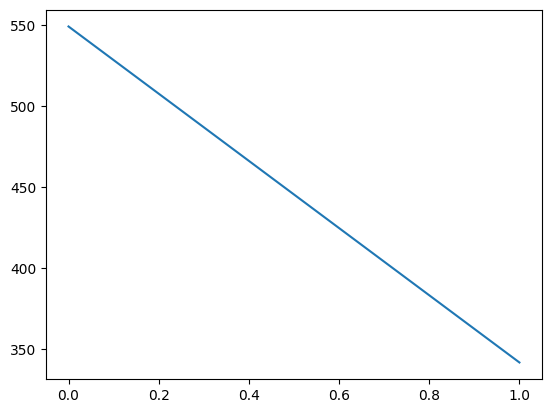

In [10]:
#checking count
plt.plot(df['Survived'].value_counts())

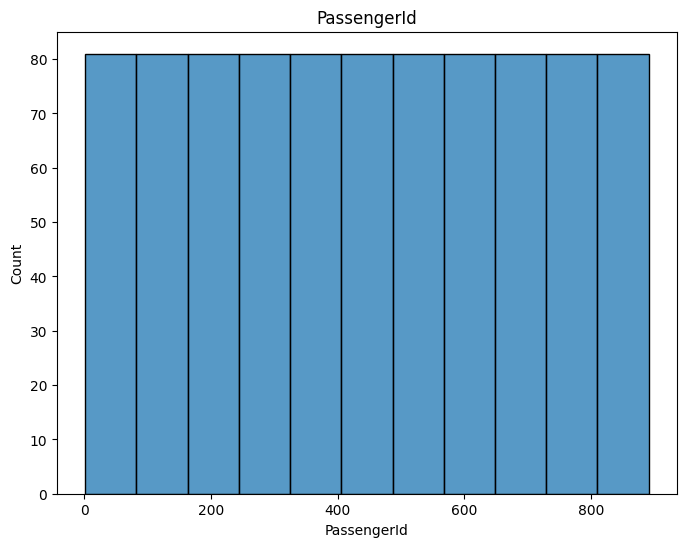

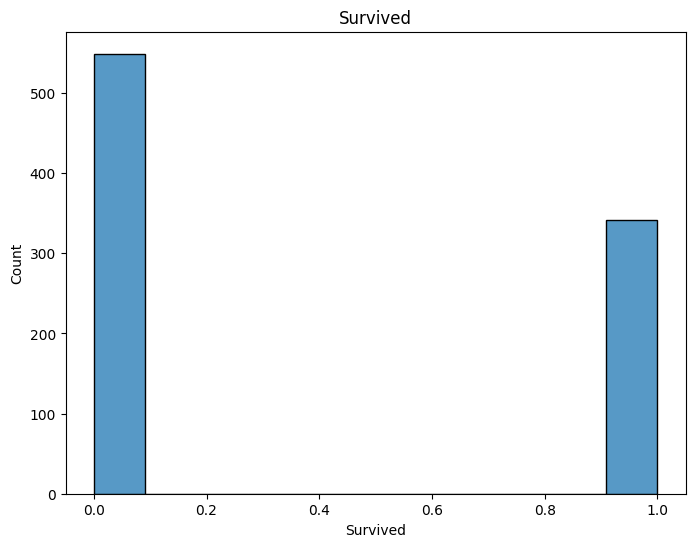

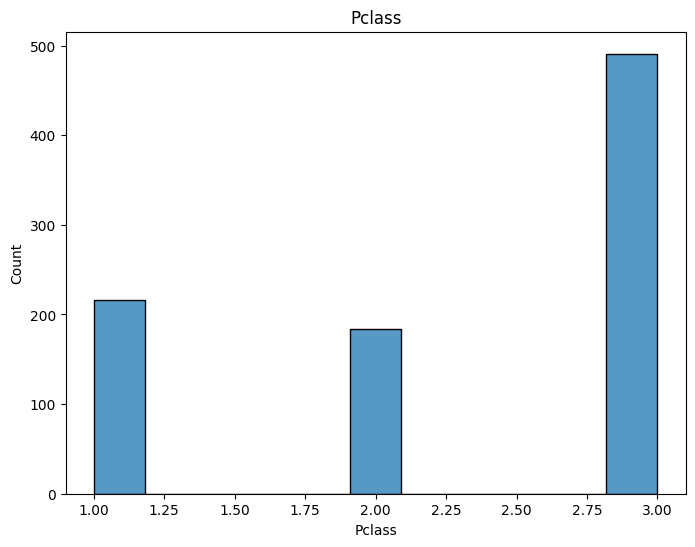

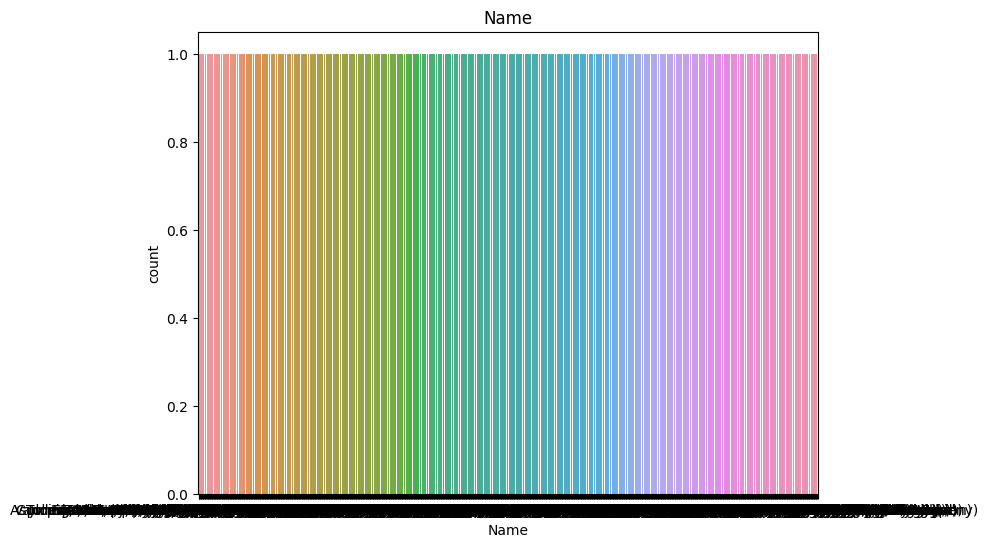

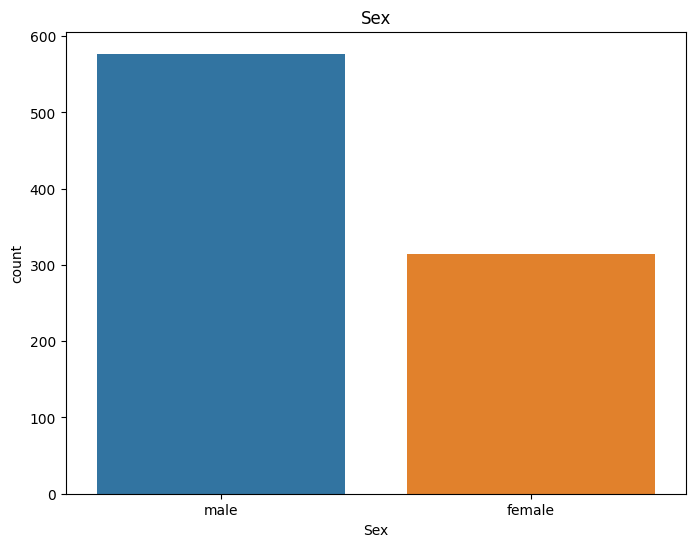

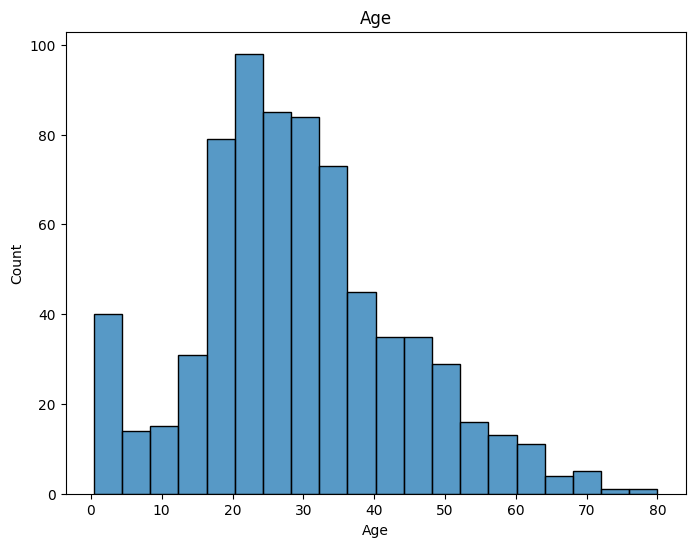

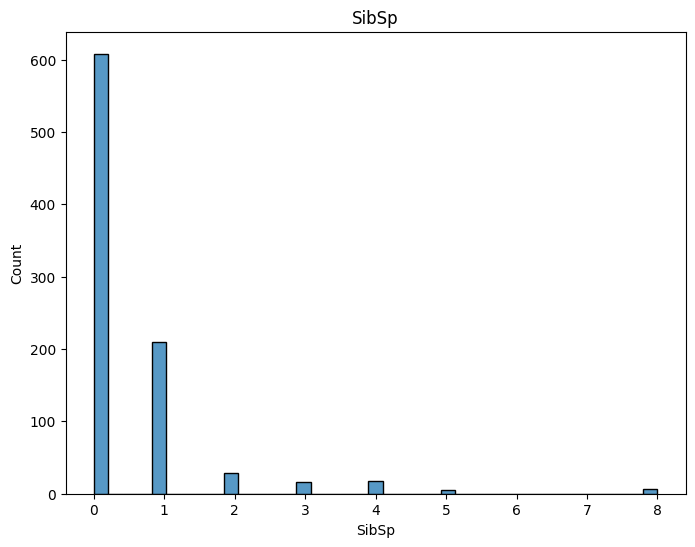

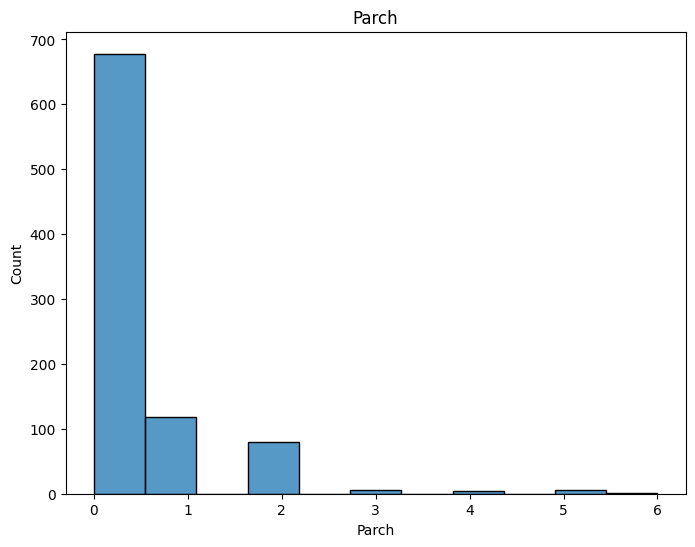

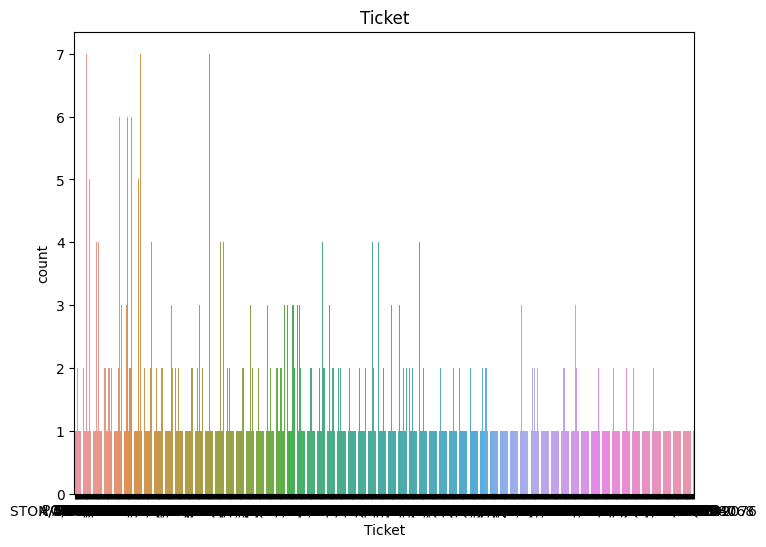

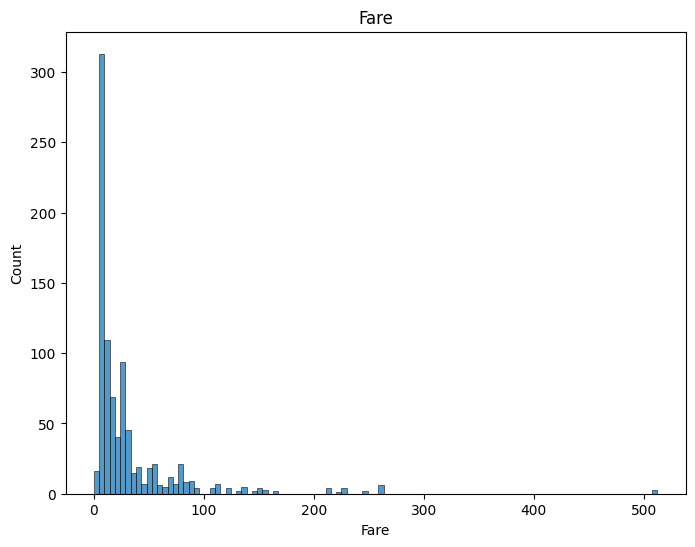

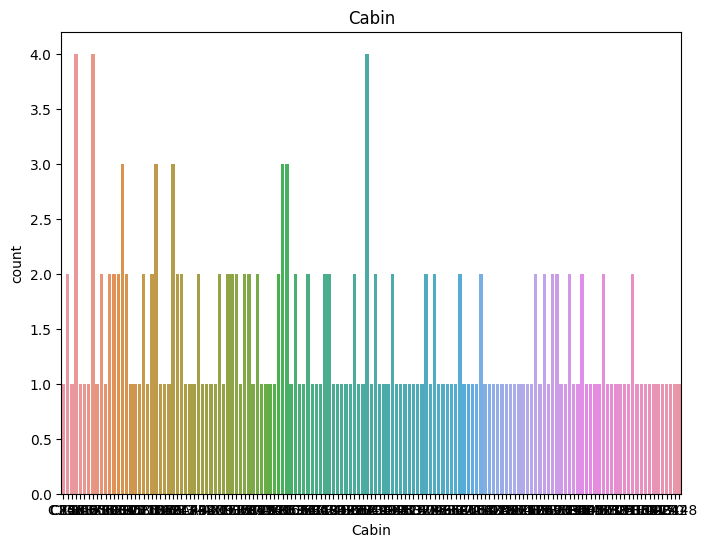

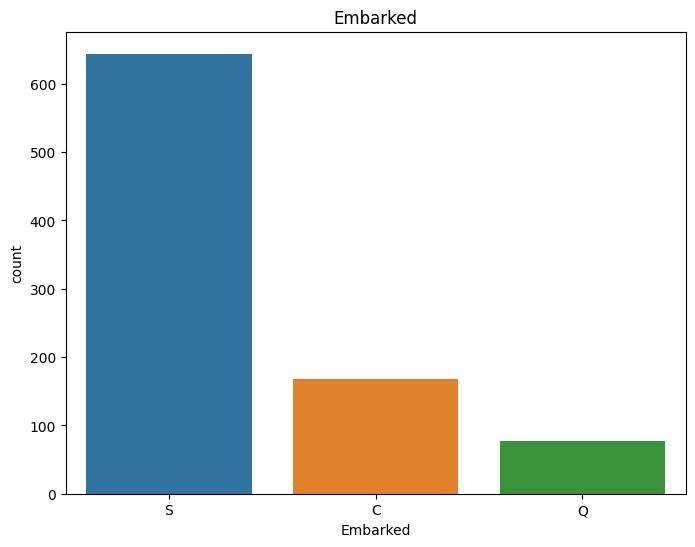

In [11]:
# Check the distribution of each feature. 

for col in df.columns:
    if df[col].dtype == 'object':
        plt.figure(figsize=(8, 6))
        sns.countplot(x=col, data=df)
        plt.title(col)
        plt.show()
    else:
        plt.figure(figsize=(8, 6))
        sns.histplot(x=col, data=df)
        plt.title(col)
        plt.show()

In [12]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

## Data Preprocessing

Predicting the missing age values:  We are using Random Forest Regressor to predict missing age values based on other features.

In [13]:

from sklearn.ensemble import RandomForestRegressor

def finding_age(df):
    # Split the dataset into a training set and a test set
    train = df[df['Age'].notnull()]
    test = df[df['Age'].isnull()]

    # Define the features and target variable
    numeric_features = ['Pclass', 'SibSp', 'Parch', 'Fare']
    categorical_features = ['Sex', 'Embarked']
    target = 'Age'

    # One-hot encode the categorical features
    train_encoded = pd.get_dummies(train, columns=categorical_features)
    test_encoded = pd.get_dummies(test, columns=categorical_features)

    #features after encoding
    encoded_features=['Sex_female', 'Sex_male', 'Embarked_C',
        'Embarked_Q', 'Embarked_S']


    train_features= pd.concat([train[numeric_features],train_encoded[encoded_features]], axis=1)
    test_features=pd.concat([test[numeric_features],test_encoded[encoded_features]],axis=1)


    # Fit a Random Forest Regressor model on the training set
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(train_features, train[target])

    
    predicted_ages = rf.predict(test_features)

    return predicted_ages

# Predict the missing age values using the trained model
df.loc[df['Age'].isnull(), 'Age'] = finding_age(df)




In [14]:
# Check for missing values in Age column
df.Age.isnull().sum()

0

Adding Has_Cabin feature to check weather the person has a cabin or not

In [15]:
# create a copy of df as df1
df1 = df.copy()

# add a new feature for cabin
df1['Has_Cabin'] = df1['Cabin'].apply(lambda x: 0 if pd.isna(x) else 1)

# drop the cabin column
df1.drop(['Cabin'], axis=1, inplace=True)

df1.head(5)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Has_Cabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,0


Filling the 2 missing values of embarked column with the most common value

In [16]:
df1['Embarked'].fillna('S', inplace=True)
df1.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Has_Cabin      0
dtype: int64

In [17]:
df1.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'Has_Cabin'],
      dtype='object')

In [18]:
#One hot encoding for the categorical columns

df1 = pd.get_dummies(df1, columns=['Sex', 'Embarked'])
df1.columns


Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Has_Cabin', 'Sex_female', 'Sex_male', 'Embarked_C',
       'Embarked_Q', 'Embarked_S'],
      dtype='object')

##  Feature Engineering

In [19]:
# Create a copy of df1 as df2
df2 = df1.copy()

# Extract the title from the name column
df2['Title'] = df2['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Group rare titles into 'Other' category
df2['Title'] = df2['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major','Mme','Ms','Mlle','Rev', 'Sir', 'Jonkheer', 'Dona'], 'Other')

# Create a new feature FamilySize by adding SibSp and Parch, plus 1 for the passenger
df2['FamilySize'] = df2['SibSp'] + df2['Parch'] + 1

# Create a new feature IsAlone indicating whether a passenger is traveling alone or not
df2['IsAlone'] = 0
df2.loc[df2['FamilySize'] == 1, 'IsAlone'] = 1

# Create age groups
df2['AgeGroup'] = pd.cut(df2['Age'], bins=[0, 12, 18, 30, 60, 100], labels=['Child', 'Teenager', 'Young Adult', 'Adult', 'Elderly'])

# create fare groups
df2['FareGroup'] = pd.cut(df2['Fare'], bins=[-1, 10, 20, 30, 1000], labels=[1, 2, 3, 4])

# Drop unnecessary columns
df2 = df2.drop([  'Name', 'SibSp', 'Parch', 'Ticket','Age','Fare'], axis=1)

df2.head(5)


,PassengerId,Survived,Pclass,Has_Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title,FamilySize,IsAlone,AgeGroup,FareGroup
0,1,0,3,0,0,1,0,0,1,Mr,2,0,Young Adult,1
1,2,1,1,1,1,0,1,0,0,Mrs,2,0,Adult,4
2,3,1,3,0,1,0,0,0,1,Miss,1,1,Young Adult,1
3,4,1,1,1,1,0,0,0,1,Mrs,2,0,Adult,4
4,5,0,3,0,0,1,0,0,1,Mr,1,1,Adult,1


In [20]:
#One hot encoding for the Title,AgeGroup and FareGroup

df2 = pd.get_dummies(df2, columns=['Title','AgeGroup', 'FareGroup'])
df2.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Has_Cabin', 'Sex_female',
       'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'FamilySize',
       'IsAlone', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Other', 'AgeGroup_Child', 'AgeGroup_Teenager',
       'AgeGroup_Young Adult', 'AgeGroup_Adult', 'AgeGroup_Elderly',
       'FareGroup_1', 'FareGroup_2', 'FareGroup_3', 'FareGroup_4'],
      dtype='object')

## preprocessing the test dataset

In [21]:
# load test data
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')

# check the missing values in each column
test_df.isnull().sum()


# fill missing fare value with the median fare
test_df['Fare'].fillna(test_df['Fare'].median(), inplace=True)

# fill missing age values using the trained model
test_df.loc[test_df['Age'].isnull(), 'Age'] = finding_age(test_df)

# create a new feature Has_Cabin indicating whether a passenger has a cabin or not
test_df['Has_Cabin'] = test_df['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

# create a new feature FamilySize by adding SibSp and Parch features
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1

# create a new feature IsAlone indicating whether a passenger is traveling alone or not
test_df['IsAlone'] = 0
test_df.loc[test_df['FamilySize'] == 1, 'IsAlone'] = 1

# create age groups
test_df['AgeGroup'] = pd.cut(test_df['Age'], bins=[0, 12, 18, 30, 60, 100], labels=['Child', 'Teenager', 'Young Adult', 'Adult', 'Elderly'])


# create fare groups
test_df['FareGroup'] = pd.cut(test_df['Fare'], bins=[-1, 10, 20, 30, 1000], labels=[1, 2, 3, 4])

# extract the title from the name column
test_df['Title'] = test_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# group rare titles into 'Other' category
test_df['Title'] = test_df['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major','Mme','Ms','Mlle', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Other')

# perform one-hot encoding on categorical columns
test_df = pd.get_dummies(test_df, columns=['Sex', 'Embarked', 'Title'])

# drop unnecessary columns
test_df.drop([ 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Fare'], axis=1, inplace=True)

# check the processed test data
test_df.head()




,PassengerId,Pclass,Has_Cabin,FamilySize,IsAlone,AgeGroup,FareGroup,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other
0,892,3,0,1,1,Adult,1,0,1,0,1,0,0,0,1,0,0
1,893,3,0,2,0,Adult,1,1,0,0,0,1,0,0,0,1,0
2,894,2,0,1,1,Elderly,1,0,1,0,1,0,0,0,1,0,0
3,895,3,0,1,1,Young Adult,1,0,1,0,0,1,0,0,1,0,0
4,896,3,0,3,0,Young Adult,2,1,0,0,0,1,0,0,0,1,0


In [22]:
test_df.isnull().sum()

PassengerId     0
Pclass          0
Has_Cabin       0
FamilySize      0
IsAlone         0
AgeGroup        0
FareGroup       0
Sex_female      0
Sex_male        0
Embarked_C      0
Embarked_Q      0
Embarked_S      0
Title_Master    0
Title_Miss      0
Title_Mr        0
Title_Mrs       0
Title_Other     0
dtype: int64

In [23]:
test_df.dtypes


PassengerId        int64
Pclass             int64
Has_Cabin          int64
FamilySize         int64
IsAlone            int64
AgeGroup        category
FareGroup       category
Sex_female         uint8
Sex_male           uint8
Embarked_C         uint8
Embarked_Q         uint8
Embarked_S         uint8
Title_Master       uint8
Title_Miss         uint8
Title_Mr           uint8
Title_Mrs          uint8
Title_Other        uint8
dtype: object

In [24]:
#One hot encoding
test_df = pd.get_dummies(test_df, columns=['AgeGroup', 'FareGroup'])
test_df.columns


Index(['PassengerId', 'Pclass', 'Has_Cabin', 'FamilySize', 'IsAlone',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other',
       'AgeGroup_Child', 'AgeGroup_Teenager', 'AgeGroup_Young Adult',
       'AgeGroup_Adult', 'AgeGroup_Elderly', 'FareGroup_1', 'FareGroup_2',
       'FareGroup_3', 'FareGroup_4'],
      dtype='object')

## Model Building


In [25]:
#defining x_train and y_train
X_train=df2.drop([ 'PassengerId','Survived'], axis=1)
y_train=df2['Survived']

Using Grid Search CV to find the best model

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from sklearn.svm import SVC
# from xgboost import XGBClassifier


# # define the models and their hyperparameters to tune
# models = [
#     {
#         'name': 'Random Forest',
#         'estimator': RandomForestClassifier(),
#         'hyperparameters': {
#             'n_estimators': [50, 100, 150],
#             'max_depth': [5, 10, None],
#             'min_samples_split': [2, 5, 10],
#             'min_samples_leaf': [1, 2, 4],
#             'max_features': ['sqrt', 'log2', None]
#         }
#     },
#     {
#         'name': 'Gradient Boosting',
#         'estimator': GradientBoostingClassifier(),
#         'hyperparameters': {
#             'n_estimators': [50, 100, 150],
#             'max_depth': [3, 5, None],
#             'min_samples_split': [2, 5, 10],
#             'min_samples_leaf': [1, 2, 4],
#             'max_features': ['sqrt', 'log2', None]
#         }
#     },
#     {
#         'name': 'SVM',
#         'estimator': SVC(probability=True),
#         'hyperparameters': {
#             'C': [0.1, 1, 10],
#             'kernel': ['linear', 'rbf', 'poly'],
#             'degree': [2, 3, 4],
#             'gamma': ['scale', 'auto']
#         }
#     },
#     {
#         'name': 'XGBoost',
#         'estimator': XGBClassifier(),
#         'hyperparameters': {
#             'n_estimators': [50, 100, 150],
#             'max_depth': [3, 5, 7],
#             'learning_rate': [0.1, 0.01, 0.001],
#             'subsample': [0.5, 0.8, 1],
#             'colsample_bytree': [0.5, 0.8, 1],
#             'gamma': [0, 1, 5]
#         }
#     }
# ]

# # loop through each model and perform grid search
# for model in models:
#     print(f"Training {model['name']}...")
#     grid = GridSearchCV(
#         estimator=model['estimator'],
#         param_grid=model['hyperparameters'],
#         scoring='accuracy',
#         cv=5,
#         n_jobs=-1
#     )

#     grid.fit(X_train,y_train)
#     print(f"Best parameters for {model['name']}: {grid.best_params_}")
#     print(f"Best score for {model['name']}: {grid.best_score_}")
#     print("\n")



In [ ]:
# best_model = grid.best_estimator_
# best_hyperparameters = grid.best_params_
# print(best_model)
# print(best_hyperparameters)


In [26]:
from xgboost import XGBClassifier

# Create an instance of the XGBClassifier with the best hyperparameters
best_model = XGBClassifier(
    colsample_bytree=0.5,
    gamma=0,
    learning_rate=0.01,
    max_depth=3,
    n_estimators=50,
    subsample=1
)

# Fit the best model on the entire training dataset
best_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

 ## evaluate model performance based on other relevant metrics

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# define a function to evaluate model performance
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]
    
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, y_prob)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    specificity = tn / (tn + fp)
    
    print("Accuracy: {:.4f}".format(accuracy))
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1-score: {:.4f}".format(f1))
    print("AUC: {:.4f}".format(auc))
    print("Specificity: {:.4f}".format(specificity))


In [28]:
evaluate_model(best_model, X_train, y_train)

Accuracy: 0.8373
Precision: 0.8127
Recall: 0.7485
F1-score: 0.7793
AUC: 0.8773
Specificity: 0.8925


## Predicting on the test data 

In [29]:

# make sure the columns in test_df are in the same order as in df2
test_df = test_df.reindex(columns=df2.columns.drop('Survived'))

# Make predictions on the test dataset
X_test = test_df.drop('PassengerId', axis=1)
test_df['Survived'] = best_model.predict(X_test)

# Create a CSV file containing passenger IDs and survival predictions
test_df[['PassengerId', 'Survived']].to_csv('submission.csv', index=False)


In [31]:
#Now checking Survive on oth Data sets

In [30]:
submission = pd.read_csv("../input/titanic/gender_submission.csv")
train = pd.read_csv("../input/titanic/train.csv",index_col="PassengerId")
test = pd.read_csv("../input/titanic/test.csv",index_col="PassengerId")

In [33]:
train.sample(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
252,0,3,"Strom, Mrs. Wilhelm (Elna Matilda Persson)",female,29.0,1,1,347054,10.4625,G6,S
733,0,2,"Knight, Mr. Robert J",male,NaN,0,0,239855,0.0000,NaN,S
402,0,3,"Adams, Mr. John",male,26.0,0,0,341826,8.0500,NaN,S
256,1,3,"Touma, Mrs. Darwis (Hanne Youssef Razi)",female,29.0,0,2,2650,15.2458,NaN,C
679,0,3,"Goodwin, Mrs. Frederick (Augusta Tyler)",female,43.0,1,6,CA 2144,46.9000,NaN,S


In [34]:
test.sample(5)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1290,3,"Larsson-Rondberg, Mr. Edvard A",male,22.0,0,0,347065,7.7750,NaN,S
911,3,"Assaf Khalil, Mrs. Mariana (Miriam"")""",female,45.0,0,0,2696,7.2250,NaN,C
1103,3,"Finoli, Mr. Luigi",male,NaN,0,0,SOTON/O.Q. 3101308,7.0500,NaN,S
1066,3,"Asplund, Mr. Carl Oscar Vilhelm Gustafsson",male,40.0,1,5,347077,31.3875,NaN,S
1071,1,"Compton, Mrs. Alexander Taylor (Mary Eliza Ing...",female,64.0,0,2,PC 17756,83.1583,E45,C


In [35]:
print("TRAIN shape",train.shape)
print("TEST shape",test.shape)

TRAIN shape (891, 11)
TEST shape (418, 10)


In [36]:
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [37]:
test.describe()

,Pclass,Age,SibSp,Parch,Fare
count,418.000000,332.000000,418.000000,418.000000,417.000000
mean,2.265550,30.272590,0.447368,0.392344,35.627188
std,0.841838,14.181209,0.896760,0.981429,55.907576
min,1.000000,0.170000,0.000000,0.000000,0.000000
25%,1.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,27.000000,0.000000,0.000000,14.454200
75%,3.000000,39.000000,1.000000,0.000000,31.500000
max,3.000000,76.000000,8.000000,9.000000,512.329200


In [38]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [39]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


In [40]:
# Checking missing values on TRAIN
train.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [41]:
# Checking missing values on TEST
test.isna().sum()

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64

In [42]:
# Checking for duplicates
print("Duplicates on TRAIN dataset:",train.duplicated().value_counts())
print("Duplicates on TEST dataset:",test.duplicated().value_counts())

Duplicates on TRAIN dataset: False    891
dtype: int64
Duplicates on TEST dataset: False    418
dtype: int64


Filling missing values on the Age column¶

In [43]:
missing_values = train[train['Age'].isnull()]
missing_values.head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q


In [44]:
age_mean = train.groupby(['Pclass', 'Sex']).agg({'Age': 'mean'})
age_mean

Age
Pclass Sex              
1      female  34.611765
       male    41.281386
2      female  28.722973
       male    30.740707
3      female  21.750000
       male    26.507589

In [45]:
# Create a copy of the datasets
df_train = train.copy()
df_test = test.copy()

# Group by "Pclass" and "Sex" and calculate the mean age
mean_age_train = df_train.groupby(["Pclass", "Sex"])['Age'].mean()
#mean_age_test = df_test.groupby(["Pclass", "Sex"])['Age'].mean()

# Create a mask for missing values in the 'Age' column
missing_values_train = df_train['Age'].isnull()
missing_values_test = df_test['Age'].isnull()

# Impute missing values in the 'Age' column using the mean values
imputer = SimpleImputer(strategy='mean')
df_train.loc[missing_values_train, 'Age'] = df_train.loc[missing_values_train].apply(lambda x: mean_age_train[(x['Pclass'], x['Sex'])], axis=1)
df_test.loc[missing_values_test, 'Age'] = df_test.loc[missing_values_test].apply(lambda x: mean_age_train[(x['Pclass'], x['Sex'])], axis=1)

In [46]:
df_train.loc[6]

Survived                   0
Pclass                     3
Name        Moran, Mr. James
Sex                     male
Age                26.507589
SibSp                      0
Parch                      0
Ticket                330877
Fare                  8.4583
Cabin                    NaN
Embarked                   Q
Name: 6, dtype: object

In [47]:
missing_values = test[test['Fare'].isnull()]
missing_values.head(5)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [48]:
fare_mean = train.groupby(['Pclass', 'Sex']).mean(numeric_only=True).Fare
fare_mean

Pclass  Sex   
1       female    106.125798
        male       67.226127
2       female     21.970121
        male       19.741782
3       female     16.118810
        male       12.661633
Name: Fare, dtype: float64

In [49]:
# Group by "Pclass" and "Sex" and calculate the mean fare
mean_fare_train = df_train.groupby(["Pclass", "Sex"])['Fare'].mean()

# Create a mask for missing value in the 'Fare' column
missing_values_test = df_test['Fare'].isnull()

# Impute missing value in the 'Fare' column using the mean values of TRAIN
imputer = SimpleImputer(strategy='mean')
imputer.fit(df_train.groupby(["Pclass", "Sex"])['Fare'].transform('mean').values.reshape(-1, 1))
df_test.loc[missing_values_test, 'Fare'] = df_test.loc[missing_values_test].apply(lambda x: mean_fare_train[(x['Pclass'], x['Sex'])], axis=1)

In [50]:
# Checking the result of the impute values on PasserID 1044
# df_test.loc[df_test['PassengerId']==1044]
df_test.loc[1044]

Pclass                       3
Name        Storey, Mr. Thomas
Sex                       male
Age                       60.5
SibSp                        0
Parch                        0
Ticket                    3701
Fare                 12.661633
Cabin                      NaN
Embarked                     S
Name: 1044, dtype: object

In [51]:
# Checking the 2 rows with missing values on 'Embarked'
df_train.loc[df_train.Embarked.isna(),:]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [52]:
# Dropping the 2 rows with missing values on 'Embarked'
df_train = df_train.drop(index=df_train.loc[df_train.Embarked.isna(),:].index)

In [53]:
grouped_data = train.groupby(['Pclass', 'Survived']).agg(
    Passenger_Count=('Pclass', 'count'),    
    Missing_Cabin_Count=('Cabin', lambda x: x.isnull().sum())
)
grouped_data

Passenger_Count  Missing_Cabin_Count
Pclass Survived                                      
1      0                      80                   21
       1                     136                   19
2      0                      97                   94
       1                      87                   74
3      0                     372                  366
       1                     119                  113

In [54]:
# Dropping the 'Cabin' column
df_train = df_train.drop(columns=["Cabin"])
df_test = df_test.drop(columns=["Cabin"])

In [55]:
# Create a function to extract the title from the name column
def extract_title(name):
    # Search for a pattern that starts with a word boundary (^) and ends with a period (\.)
    title = re.search(r'\b\w+\b\.', name)
    # If a title is found, return it, otherwise return None
    if title:
        return title.group()
    else:
        return None

# Apply the function to the Name column to create a new column called Title
df_train['Title'] = df_train['Name'].apply(extract_title)
df_test['Title'] = df_test['Name'].apply(extract_title)

In [56]:
# Remove the '.' at the end of titles in the 'Title' column
df_train['Title'] = df_train['Title'].str.rstrip('.')
df_test['Title'] = df_test['Title'].str.rstrip('.')

In [57]:
print('TRAIN unique titles:',df_train['Title'].unique())
print('TEST unique titles:',df_test['Title'].unique())

TRAIN unique titles: ['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer']
TEST unique titles: ['Mr' 'Mrs' 'Miss' 'Master' 'Ms' 'Col' 'Rev' 'Dr' 'Dona']


In [58]:
# Transform the values in the 'Title' column from 'Mme' to 'Mrs',  from 'Mlle' to 'Miss and 'Dona' to 'Lady'
df_train['Title'] = df_train['Title'].replace({'Mme': 'Mrs', 'Mlle': 'Miss'})
df_test['Title'] = df_test['Title'].replace({'Dona': 'Lady'})

In [59]:
df_train.head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Mr


EDA

   Survived  count
0         0    549
1         1    340


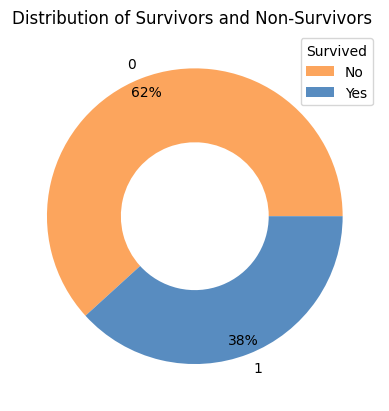

In [60]:
survived = df_train.groupby(['Survived'])['Survived'].agg(['count']).sort_values(by='count', ascending=False).reset_index()
print(survived)

# Pie chart
colors = sns.color_palette("RdYlBu")
plt.pie(survived['count'], labels=survived['Survived'], autopct='%0.0f%%', wedgeprops= dict(width=0.5),  pctdistance =0.9, colors=[colors[1], colors[5]] )
plt.title('Distribution of Survivors and Non-Survivors ')
plt.legend(title='Survived', labels=['No', 'Yes'])
plt.show()

In [61]:
def plot_count_by_class(df, column):
       
    # Create a figure and two subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    # Chart 1: Count of passengers 
    sns.countplot(ax=axes[0], x=column, data=df, color=colors[5])
    axes[0].set_xlabel(column)
    axes[0].set_ylabel('Count')
    axes[0].set_title(f'Count of {column}')

    # Chart 2: Count of survivors and non-survivors by class
    sns.countplot(ax=axes[1], x=column, hue='Survived', data=df, palette=[colors[1], colors[5]])
    axes[1].set_xlabel(column)
    axes[1].set_ylabel('Count')
    axes[1].set_title(f'Count of Survivors and Non-Survivors by {column}')
    axes[1].legend(title='Survived', labels=['No', 'Yes'])

    # Calculate the percentage values
    total_counts = len(df)
    for ax in axes:
        for p in ax.patches:
            percentage = f'{100 * p.get_height() / total_counts:.1f}%'
            ax.annotate(percentage, (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom', fontsize=8)

    # Adjust the layout to avoid overlapping labels
    plt.tight_layout()

    # Show the plot
    plt.show()

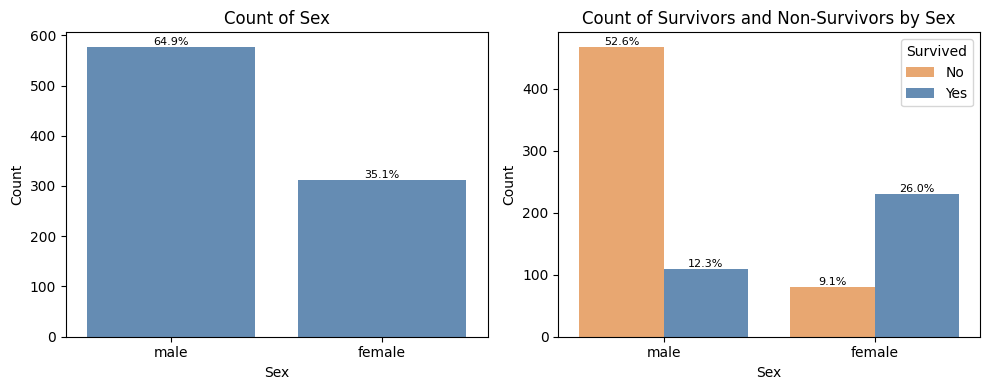

In [62]:
plot_count_by_class(df_train, 'Sex')

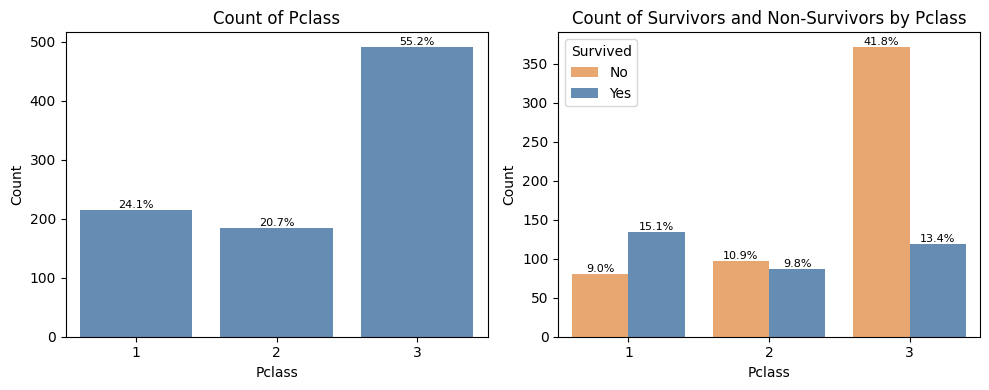

In [63]:
plot_count_by_class(df_train, 'Pclass')

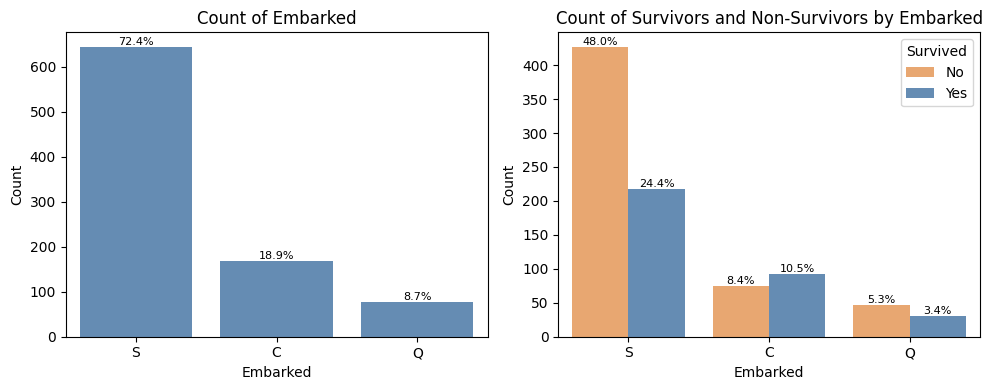

In [64]:
plot_count_by_class(df_train, 'Embarked')

In [65]:
median_fare_age = df_train.groupby(['Survived']).agg({'Age': 'median', 'Fare': 'median'})
median_fare_age

,Age,Fare
Survived,,
0,26.507589,10.5
1,27.000000,26.0


In [66]:
def create_subplots(df, column):
    # Create a figure with two subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    # Plot 1: Kernel density plot
    sns.kdeplot(ax=axes[0], data=df, x=column, common_norm=False, hue='Survived', fill=True, palette=[colors[5], colors[1]])
    axes[0].set_title(f'Kernel Density Plot of {column}')
    axes[0].set_xlabel(column)
    axes[0].set_ylabel('Density')
    axes[0].legend(title='Survived', labels=['No', 'Yes'])

    # Plot 2: Boxplot
    sns.boxplot(ax=axes[1], data=df, x="Survived", y=column, palette=[colors[1], colors[5]])
    axes[1].set_title(f'Boxplot of {column}')
    axes[1].set_xlabel('Survived')
    axes[1].set_ylabel(column)

    plt.tight_layout()
    plt.show()

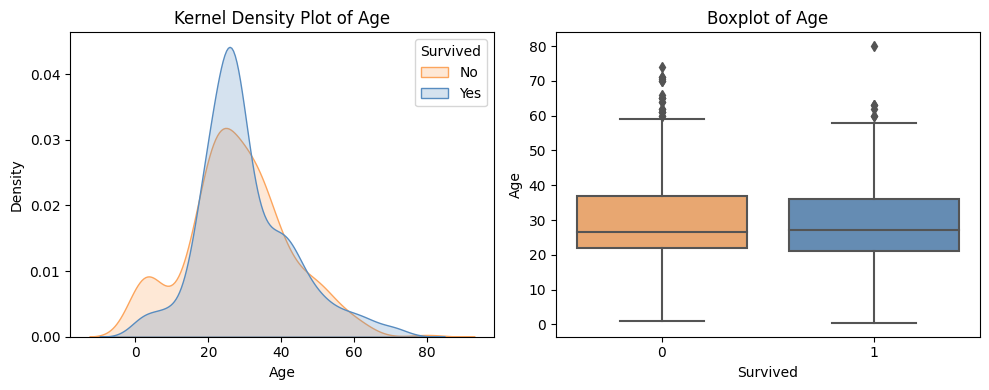

In [67]:
create_subplots(df_train, 'Age')

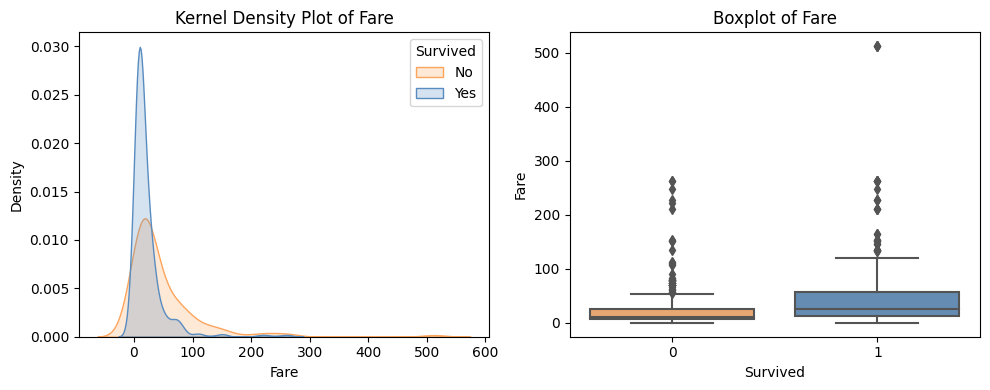

In [68]:
create_subplots(df_train, 'Fare')

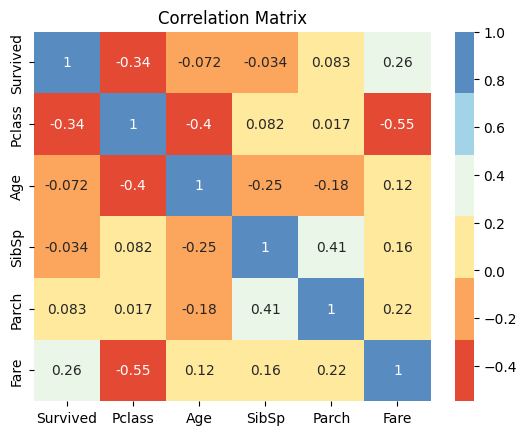

In [69]:
# Calculate the correlation matrix
corr_matrix = df_train.corr(numeric_only=True)
# Create a heatmap of the correlation matrix
sns.heatmap(corr_matrix, cmap=colors, annot=True)

plt.title('Correlation Matrix')
plt.show()

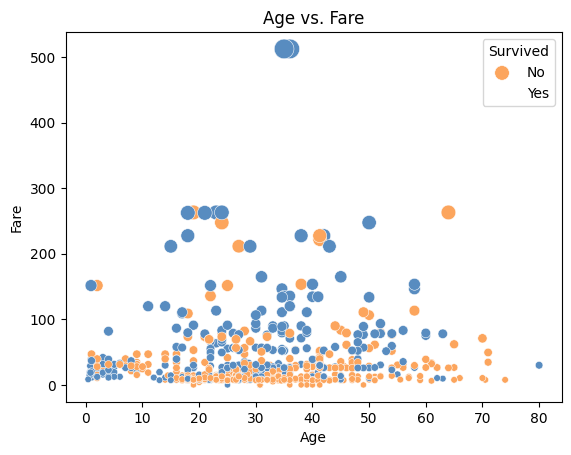

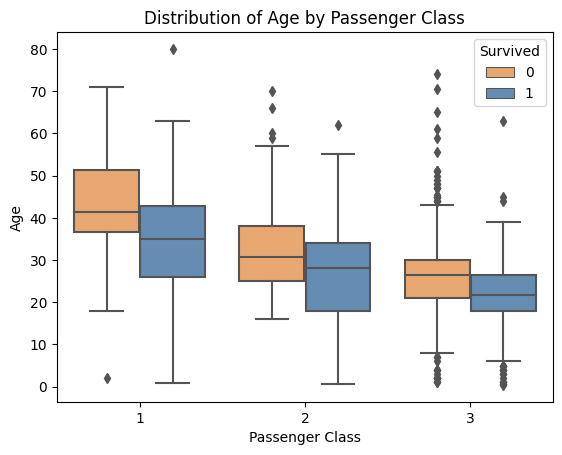

In [70]:
sns.scatterplot(data=df_train, y='Fare', x='Age', hue='Survived', size="Fare", sizes=(20, 200),palette=[colors[1], colors[5]])
plt.title('Age vs. Fare')
plt.xlabel('Age')
plt.ylabel('Fare')
plt.legend(title='Survived', labels=['No', 'Yes'])
plt.show()

sns.boxplot(data=df_train, x='Pclass', y='Age', hue= 'Survived', palette=[colors[1], colors[5]])
plt.xlabel('Passenger Class')
plt.ylabel('Age')
plt.title('Distribution of Age by Passenger Class')
plt.show()


In [71]:
df_train[df_train.Fare == df_train.Fare.max() ]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
PassengerId,,,,,,,,,,,
259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,C,Miss
680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,C,Mr
738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,C,Mr


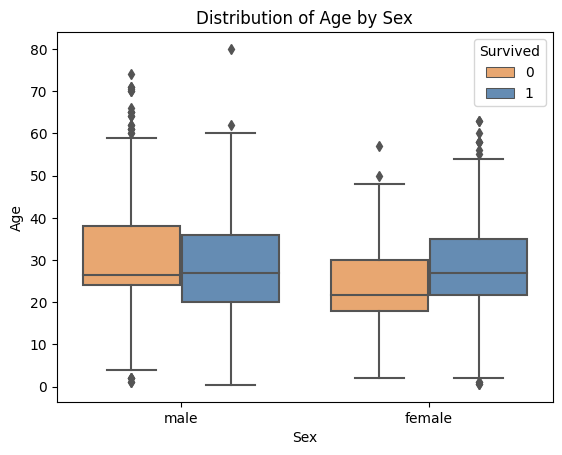

In [72]:
sns.boxplot(data=df_train, x='Sex', y='Age', hue= 'Survived', palette=[colors[1], colors[5]])
plt.ylabel('Age')
plt.title('Distribution of Age by Sex')
plt.show()

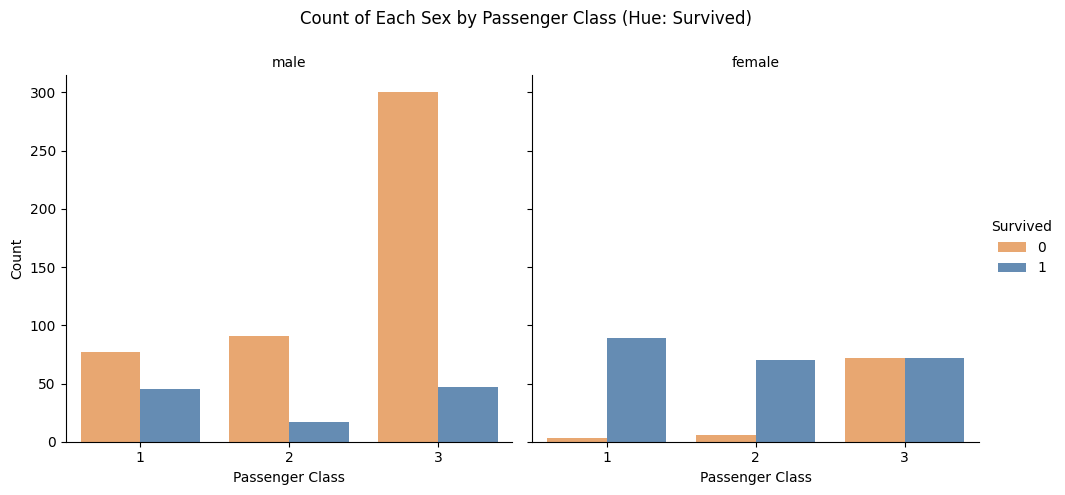

In [73]:
g = sns.catplot(data=df_train, x='Pclass', hue='Survived', col='Sex', kind='count', palette=[colors[1], colors[5]])
g.set_axis_labels('Passenger Class', 'Count')
g.set_titles('{col_name}')
g.fig.subplots_adjust(top=0.85)  # Adjust the spacing at the top
g.fig.suptitle('Count of Each Sex by Passenger Class (Hue: Survived)')
plt.show()

In [74]:
df_train = df_train.drop(['Name', 'Ticket'], axis=1)
df_test = df_test.drop(['Name', 'Ticket'], axis=1)

In [75]:
# Initialize the LabelEncoder
encoder = LabelEncoder()

# Fit and transform the 'Title' column in the training data
df_train['Title'] = encoder.fit_transform(df_train['Title'])
# Transform the 'Title' column in the test data
df_test['Title'] = encoder.transform(df_test['Title'])
df_train.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,10
2,1,1,female,38.0,1,0,71.2833,C,11
3,1,3,female,26.0,0,0,7.9250,S,9
4,1,1,female,35.0,1,0,53.1000,S,11
5,0,3,male,35.0,0,0,8.0500,S,10


In [76]:
# Fit and transform the 'Embarked' column
df_train['Embarked'] = encoder.fit_transform(df_train['Embarked'])
df_test['Embarked'] = encoder.transform(df_test['Embarked'])
df_train.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,2,10
2,1,1,female,38.0,1,0,71.2833,0,11
3,1,3,female,26.0,0,0,7.9250,2,9
4,1,1,female,35.0,1,0,53.1000,2,11
5,0,3,male,35.0,0,0,8.0500,2,10


In [77]:
# Fit and transform the 'Sex' column
df_train['Sex'] = encoder.fit_transform(df_train['Sex'])
df_test['Sex'] = encoder.transform(df_test['Sex'])
df_train.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,2,10
2,1,1,0,38.0,1,0,71.2833,0,11
3,1,3,0,26.0,0,0,7.9250,2,9
4,1,1,0,35.0,1,0,53.1000,2,11
5,0,3,1,35.0,0,0,8.0500,2,10


In [78]:
# Create the 'Family Size' column
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1
df_train.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize
PassengerId,,,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,2,10,2
2,1,1,0,38.0,1,0,71.2833,0,11,2
3,1,3,0,26.0,0,0,7.9250,2,9,1
4,1,1,0,35.0,1,0,53.1000,2,11,2
5,0,3,1,35.0,0,0,8.0500,2,10,1


# Logistic Regression

In [79]:
X_train = df_train.drop('Survived',axis=1) # Independet variable/ Attributes
y_train = df_train['Survived'] # dependent variable / Label
X_test = df_test.copy()

In [80]:
# Logistic regression
lr_model = LogisticRegression(random_state=0,max_iter=1000)
lr_model.fit(X_train,y_train)
lr_y_pred = lr_model.predict(X_test)

In [83]:
# Perform cross-validation
scores_lr = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='accuracy') # The 'cv' parameter determines the number of cross-validation folds (in this case, 5-fold cross-validation is used)
# Accuracy score - Return the mean accuracy on the given TRAIN data and labels
print("Accuracy score on X_train")
print(lr_model.score(X_train, y_train)) 

Accuracy score on X_train
0.8087739032620922


In [84]:
# Print the cross-validation scores
print("Cross-Validation Accuracy Scores:", scores_lr)
print("Average Accuracy:", scores_lr.mean()) # The average accuracy score across the cross-validation folds

Cross-Validation Accuracy Scores: [0.7752809  0.81460674 0.79775281 0.78651685 0.81920904]
Average Accuracy: 0.7986732685837619


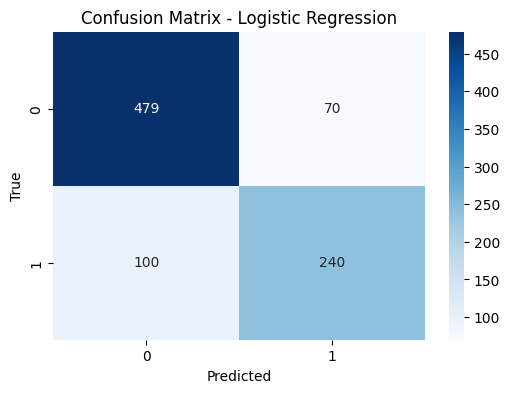

In [85]:
# Generate predictions on the training set
y_train_pred = lr_model.predict(X_train)

# Confusion matrix
confusion = confusion_matrix(y_train, y_train_pred)

# Plotting the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

In [86]:
# Training the algorithm
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train) 
rf_y_pred = classifier.predict(X_test)

In [87]:
# Using cross-validation to estimate the model performance. 
# Perform cross-validation
scores = cross_val_score(classifier, X_train, y_train, cv=5, scoring='accuracy') 

# Print the cross-validation scores
print("Cross-Validation Accuracy Scores:", scores)
print("Average Accuracy:", scores.mean()) 

Cross-Validation Accuracy Scores: [0.80898876 0.79213483 0.84831461 0.7752809  0.81355932]
Average Accuracy: 0.8076556846314988


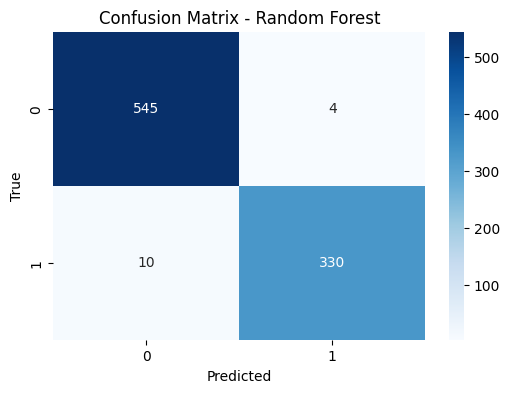

In [88]:
# Generate predictions on the training set
y_train_pred_RF = classifier.predict(X_train)

# Confusion matrix
confusion = confusion_matrix(y_train, y_train_pred_RF)

# Plotting the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Random Forest')
plt.show()

In [89]:
submission_lr = submission.copy()
submission_lr['Survived'] = lr_y_pred
submission_lr['Survived'] = submission_lr['Survived'].astype('int')
submission_lr.to_csv('submission_lr.csv', index='False')

In [90]:
submission_rf = submission.copy()
submission_rf['Survived'] = rf_y_pred
submission_rf['Survived'] = submission_rf['Survived'].astype('int')
submission_rf.to_csv('submission.csv', index=False)